In [66]:
from scipy.stats import beta, genextreme
import numpy as np
import matplotlib.pyplot as plt
from aje.stats.distributions import genmaxima, pacal_to_scipy
from aje.special import xi_from_zbc
from aje.special.xi_and_zbc import init_guess
from scipy import special
import pacal as pc
from tqdm import tqdm

In [68]:
def mu_transform(mu, sigma, xi, N):
    return mu - sigma/xi * (1-N**xi)
def sigma_transform(mu, sigma, xi, N):
    return sigma * N**xi
def gev_params_transform(mu, sigma, xi, N):
    return mu_transform(mu, sigma, xi, N), sigma_transform(mu, sigma, xi, N), xi

def pacal_genextreme(mu, sigma, xi):
    k = -1/xi
    lmbda = sigma*k
    pacal_dist = pc.WeibullDistr(k=k, lmbda=lmbda)
    pacal_dist = mu - sigma / xi - pacal_dist
    return pacal_dist

def get_genextremme_params(E, S, zb):
    dist_mean = E
    dist_std = S
    upper_bound = zb
    dist_zbc = (upper_bound - dist_mean)/dist_std #centered upper bound
    xi = xi_from_zbc(dist_zbc, init_guess([dist_zbc]))[0];
    g1 = special.gamma(1-xi)
    kx = (dist_mean - upper_bound)/g1
    sigma = kx*xi
    mu = dist_mean - kx*(g1-1)
    return mu, sigma, xi

In [100]:
k = 1.0
N = 100_000

beta_X = 5.5
beta_Y = 12.5
X_dist = pc.BetaDistr(alpha=9.21, beta=beta_X) * 1.
Y_dist = pc.BetaDistr(alpha=5.3, beta=beta_Y) * 1.
# Y_dist = pc.TrapezoidalDistr(a=0.0, b=0.9, c=0.9, d=1.0) * 0.5

Z_dist = X_dist + k*Y_dist
Z_sdist = pacal_to_scipy(Z_dist)
MZ_sdist = genmaxima(Z_sdist, N)
X_sdist = pacal_to_scipy(X_dist)
MX_sdist = genmaxima(X_sdist, N)
Y_sdist = pacal_to_scipy(Y_dist)
MY_sdist = genmaxima(Y_sdist, N)

MX_params = MX_sdist.get_genextreme_parameter()
MX_transformed_params = gev_params_transform(*MX_params, 1/N)
X_approxed_dist = pacal_genextreme(*MX_transformed_params)

MY_params = MY_sdist.get_genextreme_parameter()
MY_transformed_params = gev_params_transform(*MY_params, 1/N)
Y_approxed_dist = pacal_genextreme(*MY_transformed_params)

Z_approxed_dist = X_approxed_dist + k*Y_approxed_dist
MZ_approxed_dist = pc.iid_max(Z_approxed_dist, N)
E = MZ_approxed_dist.mean()
S = MZ_approxed_dist.std()
zb = Z_dist.range()[1]
mu, sigma, xi = get_genextremme_params(E, S, zb)
Z_approxed_sdist = pacal_to_scipy(Z_approxed_dist)
MZ_approxed_sdist = genmaxima(Z_approxed_sdist, N)

print("Genextreme parameters of MX:", MX_sdist.get_genextreme_parameter())
print("Genextreme parameters of MY:", MY_sdist.get_genextreme_parameter())
print("Genextreme parameters of MZ:", MZ_sdist.get_genextreme_parameter())
print("Genextreme parameters of MZ (approx, PaCAL):", mu, sigma, xi)
print("Genextreme parameters of MZ (approx, scipy):", MZ_approxed_sdist.get_genextreme_parameter())

Genextreme parameters of MX: (0.9683178457064241, 0.005979269489591798, -0.18872673348491947)
Genextreme parameters of MY: (0.7729182448342884, 0.019805817035029812, -0.0872188829991059)
Genextreme parameters of MZ: (1.5716877388915282, 0.027865333875335345, -0.06505845479001673)
Genextreme parameters of MZ (approx, PaCAL): 1.5878432013990467 0.02479934484688056 -0.06016968525342966
Genextreme parameters of MZ (approx, scipy): (1.5878432014229995, 0.024799344847285708, -0.06016968525790947)


### Compute over different N

In [101]:
# Compute over different N
N_array = np.logspace(5, 10, 10, dtype=int)
Z_xi_array = np.zeros(N_array.shape)
Z_approx_xi_array = np.zeros(N_array.shape)
for i, N in enumerate(tqdm(N_array)):
    MX_sdist.set_N(N)
    MY_sdist.set_N(N)
    MZ_sdist.set_N(N)
    Z_xi = MZ_sdist.get_genextreme_parameter()[2]
    Z_xi_array[i] = Z_xi

    MX_params = MX_sdist.get_genextreme_parameter()
    MX_transformed_params = gev_params_transform(*MX_params, 1/N)
    X_approxed_dist = pacal_genextreme(*MX_transformed_params)

    MY_params = MY_sdist.get_genextreme_parameter()
    MY_transformed_params = gev_params_transform(*MY_params, 1/N)
    Y_approxed_dist = pacal_genextreme(*MY_transformed_params)

    Z_approxed_dist = X_approxed_dist + k*Y_approxed_dist
    Z_approxed_sdist = pacal_to_scipy(Z_approxed_dist)
    MZ_approxed_sdist = genmaxima(Z_approxed_sdist, N)
    Z_approx_xi = MZ_approxed_sdist.get_genextreme_parameter()[2]
    Z_approx_xi_array[i] = Z_approx_xi



 80%|████████  | 8/10 [00:05<00:01,  1.42it/s]/home/default/Documents/PhD/Python Packages/alea-jacta-est/aje/stats/utils.py:95: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func = xk_fx, a = integral_lb, b = integral_ub, **integral_kwargs)[0]
100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Text(0, 0.5, 'Error in $\\xi$ (%)')

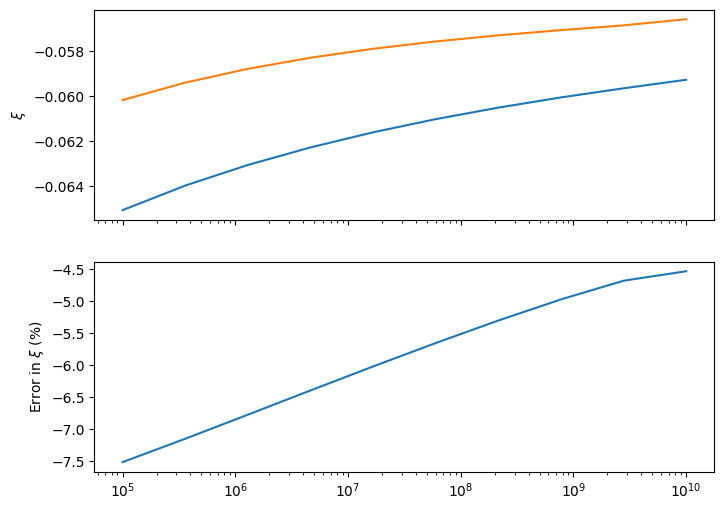

In [102]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax = axs[0]
ax.plot(N_array, Z_xi_array, label="Z")
ax.plot(N_array, Z_approx_xi_array, label="Z approx")
ax.set_xscale("log")
ax.set_ylabel(r"$\xi$")

ax = axs[1]
ax.plot(N_array, (Z_approx_xi_array - Z_xi_array) / Z_xi_array * 100., label="Z approx error")
ax.set_ylabel("Error in $\\xi$ (%)")

### Compute over different k

In [103]:
# Compute over different N
N = int(1e7)
k_array = np.linspace(0.1, 0.9, 25)

X_sdist = pacal_to_scipy(X_dist)
MX_sdist = genmaxima(X_sdist, N)
Y_sdist = pacal_to_scipy(Y_dist)
MY_sdist = genmaxima(Y_sdist, N)

MX_params = MX_sdist.get_genextreme_parameter()
MX_transformed_params = gev_params_transform(*MX_params, 1/N)
X_approxed_dist = pacal_genextreme(*MX_transformed_params)

MY_params = MY_sdist.get_genextreme_parameter()
MY_transformed_params = gev_params_transform(*MY_params, 1/N)
Y_approxed_dist = pacal_genextreme(*MY_transformed_params)

Z_xi_array = np.zeros(k_array.shape)
Z_approx_xi_array = np.zeros(k_array.shape)
for i, k in enumerate(tqdm(k_array)):
    Z_dist = (1-k)*X_dist + k*Y_dist
    Z_sdist = pacal_to_scipy(Z_dist)
    MZ_sdist = genmaxima(Z_sdist, N)
    Z_xi = MZ_sdist.get_genextreme_parameter()[2]
    Z_xi_array[i] = Z_xi

    Z_approxed_dist = (1-k)*X_approxed_dist + k*Y_approxed_dist
    Z_approxed_sdist = pacal_to_scipy(Z_approxed_dist)
    MZ_approxed_sdist = genmaxima(Z_approxed_sdist, N)
    Z_approx_xi = MZ_approxed_sdist.get_genextreme_parameter()[2]
    Z_approx_xi_array[i] = Z_approx_xi

100%|██████████| 25/25 [00:14<00:00,  1.79it/s]


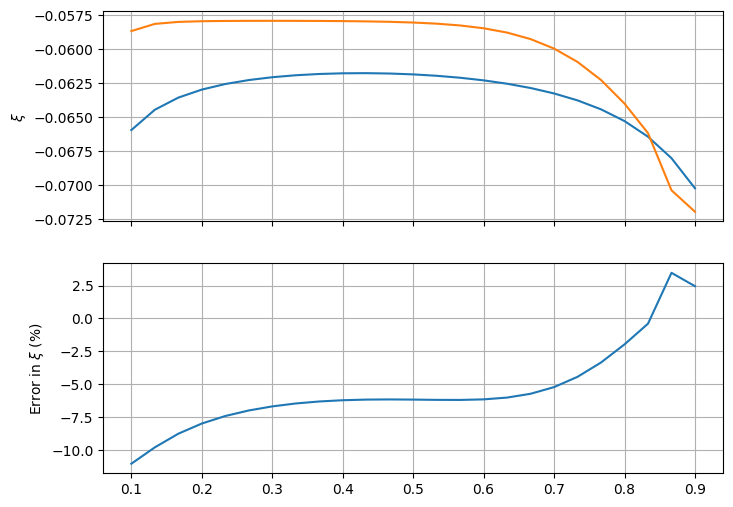

In [104]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax = axs[0]
ax.plot(k_array, Z_xi_array, label="Z")
ax.plot(k_array, Z_approx_xi_array, label="Z approx")
ax.set_ylabel(r"$\xi$")

ax = axs[1]
ax.plot(k_array, ((Z_approx_xi_array - Z_xi_array ) / Z_xi_array) * 100., label="Z approx error")
ax.set_ylabel("Error in $\\xi$ (%)")

for ax in axs:
    ax.grid()

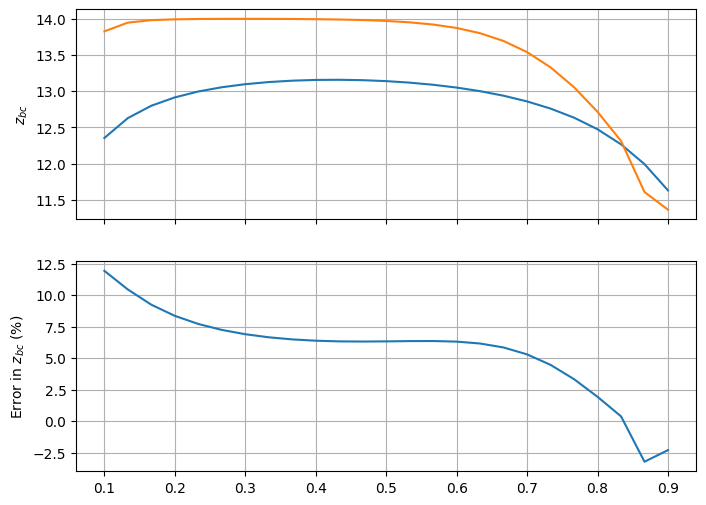

In [105]:
from aje.special import zbc_from_xi

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax = axs[0]
zbc_array = zbc_from_xi(Z_xi_array)
zbc_approx_array = zbc_from_xi(Z_approx_xi_array)

ax.plot(k_array, zbc_array, label="Z")
ax.plot(k_array, zbc_approx_array, label="Z approx")
ax.set_ylabel(r"$z_{bc}$")

ax = axs[1]
ax.plot(k_array, ((zbc_approx_array - zbc_array ) / zbc_array) * 100., label="Z approx error")
ax.set_ylabel(r"Error in $z_{bc}$ (%)")

for ax in axs:
    ax.grid()

# Other stuff

In [207]:
from scipy.integrate import quad
def conv(f, g, x, a=-np.inf, b=-np.inf, **kwargs):
    def h(t, x):
        return f(t)*g(x-t)
    return quad(h, a=a, b=b, args=x, **kwargs)[0]
conv = np.vectorize(conv)

In [212]:
#Find the alpha from the von mises condition
eps = 1e-1
w_x = X_dist.range()[1]
w_y = Y_dist.range()[1]
w_z = w_x + k*w_y

#Convolution integral limit
a_x = X_dist.range()[0]
a_y = Y_dist.range()[0]
a_z = a_x + k*a_y
b_z = w_z

z = w_z-eps
# fz = lambda z: conv(X_dist.pdf, Y_dist.pdf, z, a=a_z, b=b_z, limit=200)
# Fz = lambda z: conv(X_dist.pdf, Y_dist.cdf, z, a=a_z, b=b_z, limit=10000)
fz = Z_approxed_dist.pdf
Fz = Z_approxed_dist.cdf
alpha = (w_z - z) * fz(z) / (1-Fz(z))
xi = -1/alpha
alpha, xi

(9.396772533408058, -0.10641951759976424)

In [189]:
X_sdist.pdf(z)

0.0

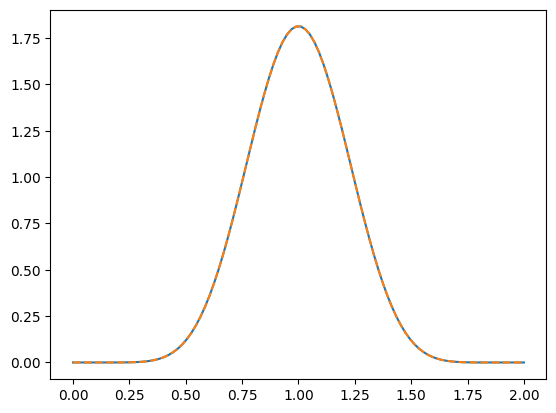

In [178]:
x = np.linspace(a_z, b_z, 100)
plt.plot(x, fz(x))
plt.plot(x, Z_dist.pdf(x), ls='--')

In [ ]:
# eps = 1e-1
# z = w_z-eps
# # Find the alpha using the approximated distribution
# fz = lambda z: conv(X_approxed_dist.pdf, Y_approxed_dist.pdf, z, a=b_z, b=b_z, limit=200)
# # Fz = lambda z: conv(X_dist.pdf, Y_dist.cdf, z, a=a_z, b=b_z)
# Fz = Z_dist.cdf
# alpha = (w_z - z) * fz(z) / (1-Fz(z))
# xi = -1/alpha
# alpha, xi

(0.0, -inf)

In [164]:
z

1.9

In [163]:
conv(X_dist.pdf, Y_dist.pdf, z, a=b_z, b=b_z, limit=int(10))

array(0.)

In [147]:
x = np.linspace(a_z, z, 25)
type(conv(X_dist.pdf, Y_dist.pdf, x, a=a_z, b=b_z)[-1])

numpy.float64

In [134]:
Z_dist.pdf(x)[-1]

1.004624337523568e-09

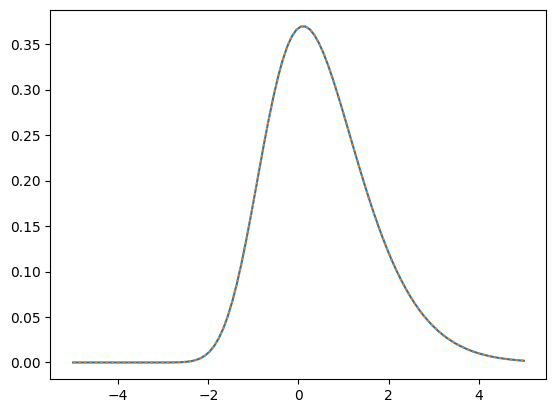

In [204]:
mu = 0.0
sigma = 1.0
xi = -0.1

k = -1/xi
lmbda = sigma*k

scipy_dist = genextreme(loc=mu, scale=sigma, c=-xi)
pacal_dist = pacal_genextreme(mu, sigma, xi)

#plot pdf
x = np.linspace(-5, 5, 100)
# x_max = mu - sigma / xi
# y = x_max - x
plt.plot(x, scipy_dist.pdf(x), label='scipy genextreme')
plt.plot(x, pacal_dist.pdf(x), label='pacal genextreme', ls=':')